In [8]:
!pip install category_encoders
!pip install xgboost
!pip install plotly_express
!pip install dash
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

In [2]:
import pandas as pd
import plotly_express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


df = pd.read_csv('https://raw.githubusercontent.com/GitNick88/GitNick88.github.io/master/insurance.csv')

# Display more columns 
pd.set_option('display.max_rows', 500)

print(df.shape)
print('hello')
df.head()

(1338, 7)
hello


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data Exploration and visualization:

In [3]:
# Types of data in the df
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [4]:
# Visual of min, max counts, etc.
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
# Checking for high cardinality columns
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [6]:
# Establish BASELINE for target, trying to predict how much a customer will cost the insurance company
guess = df['charges'].mean()
print(f'Just guessing, we would predict that insurance will cost ${guess:,.2f} per customer.  This is our model baseline.')

Just guessing, we would predict that insurance will cost $13,270.42 per customer.  This is our model baseline.


In [7]:
# What would be the average cost if I didn't insure anyone who smokes?
df_no_smoke= df.loc[df['smoker'] == 'no']

no_smoke_y_pred = df_no_smoke['charges'].mean()

no_smoke_decrease = 100 - ((no_smoke_y_pred / guess) * 100) # Calculating the % decrease in costs

print('Average insurance charges without smokers: $', no_smoke_y_pred)
print(f'By removing smokers from the dataset, premiums dropped by {no_smoke_decrease:,.0f}%')

Average insurance charges without smokers: $ 8434.268297856199
By removing smokers from the dataset, premiums dropped by 36%


In [8]:
# Let's see what happens to average costs when we remove obesity values > 26
df_obese = df.loc[df['bmi'] < 26]
df_obese_cost = df_obese['charges'].mean()

#print
df_obese_cost

10368.051867728705

In [9]:
# Remove obese (bmi > 30) and smokers to see total charges
# Baseline prediction of avg total charges was $13,152.18

df_goodbmi_nosmoke = df.loc[df['smoker'] == 'no']

df_goodbmi_nosmoke.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


In [10]:
# Average cost to the insurance company without obese (bmi > 30) and without smoker is $7977.
# What if we dropped the bmi paramter down to 26 (still considered overweight)?

df_goodbmi_nosmoke['charges'].mean()

8434.268297856199

In [11]:
# Who is more expensive?  Men or women?
df_male = df.loc[df['sex'] == 'male']

df_female = df.loc[df['sex'] == 'female']

print('Males:', df_male['charges'].mean())
print('Females:', df_female['charges'].mean())

Males: 13956.751177721886
Females: 12569.57884383534


# Create, train and test model:

In [12]:
# Train/test split 80/20
train, test = train_test_split(df, test_size=0.2)

print(train.shape)
test.shape

(1070, 7)


(268, 7)

In [13]:
# Train/val split 80/20
train, val = train_test_split(train, test_size=0.2)

print(train.shape)
print(val.shape)
test.shape

(856, 7)
(214, 7)


(268, 7)

In [14]:
# Create target, features to prep to fit and predict model
target = 'charges'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

model = LinearRegression()

# print everything just to check dimensions
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_val.shape)
print(y_train.shape)
y_test.shape

(856, 6)
(214, 6)
(268, 6)
(214,)
(856,)


(268,)

In [25]:
# Make pipeline for gradient boost
gb = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

# Fit & predict for gradient boosting R^2 score
gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.8547560190728608


In [16]:
# Train Error
y_pred = [guess] * len(y_train)
mae_train = mean_absolute_error(y_train, y_pred)
print(f'Train Error: ${mae_train:.2f}')

# Test Error
y_pred = [guess] * len(y_test)
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Test Error: ${mae_test:.2f}')
print('The train and test error are better than our baseline:')

Train Error: $9196.59
Test Error: $8677.83
The train and test error are better than our baseline:


In [28]:
# Pipeline for LinearRegression
pipeline = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

# Fit with LinearRegression and R^2 score
pipeline.fit(X_train, y_train)
print('Linear Regression R^2', pipeline.score(X_val, y_val))

Linear Regression R^2 0.7715828922481838


In [18]:
# Actual prediction with artificial data run against the model
ex_data = {'age': [27], 'sex': ['male'], 'bmi': [24], 'children': [2], 'smoker': ['no'], 'region': ['northwest']}


ex_data = pd.DataFrame(ex_data)

new_prediction = np.array2string(pipeline.predict(ex_data))
# new_prediction
print('This is the cost for someone with the above features:', new_prediction)

This is the cost for someone with the above features: [3596.36079526]


In [19]:
# Similar to above cell but includes the input functions
sex = input("Sex? male or female: ")
bmi = input("What's your bmi? ")
children = input("How many children do you have? ")
age = input("What's your age? ")
region = input("Region? ex: northwest: ")
smoker = input("Are you a smoker? yes or no: ")

ex_data = {'age': [age], 'sex': [sex], 'bmi': [bmi], 'children': [children], 'smoker': [smoker], 'region': [region]}

ex_data = pd.DataFrame(ex_data)

new_prediction = np.array2string(pipeline.predict(ex_data))
# new_prediction
print('This is the cost for someone with the above features:', new_prediction)

Sex? male or female: male
What's your bmi? 24
How many children do you have? 2
What's your age? 27
Region? ex: northwest: northwest
Are you a smoker? yes or no: no
This is the cost for someone with the above features: [3596.36079526]


# Visualizations

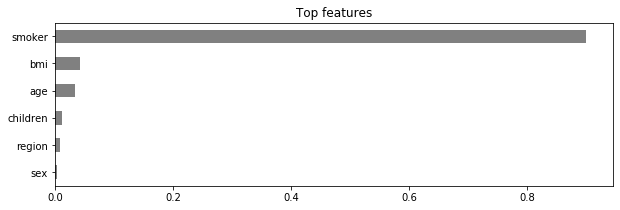

In [20]:
# Get feature importances
rf = gb.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline

n = 6
plt.figure(figsize=(10,n/2))
plt.title(f'Top features')
importances.sort_values()[-n:].plot.barh(color='grey');

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1da6168c1c8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1da616f9988>})

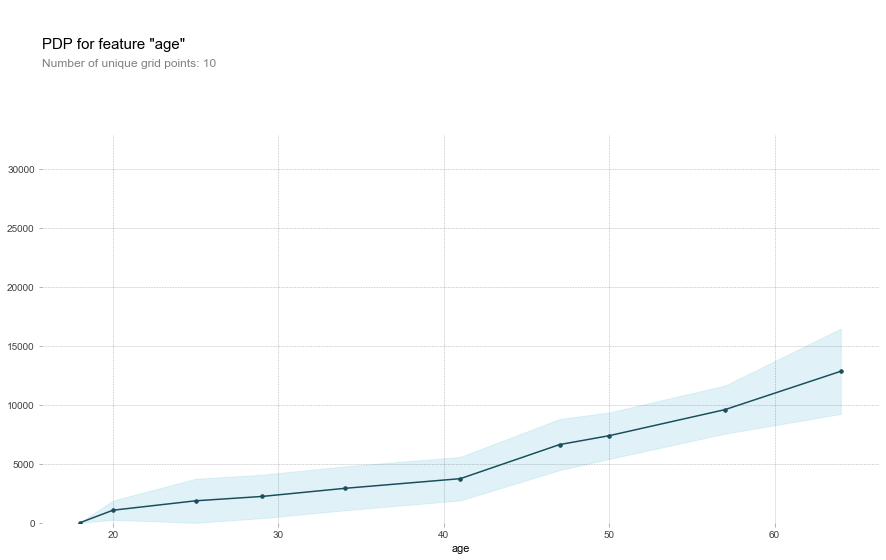

In [21]:
# PDP Plot:
feature = 'age'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature)

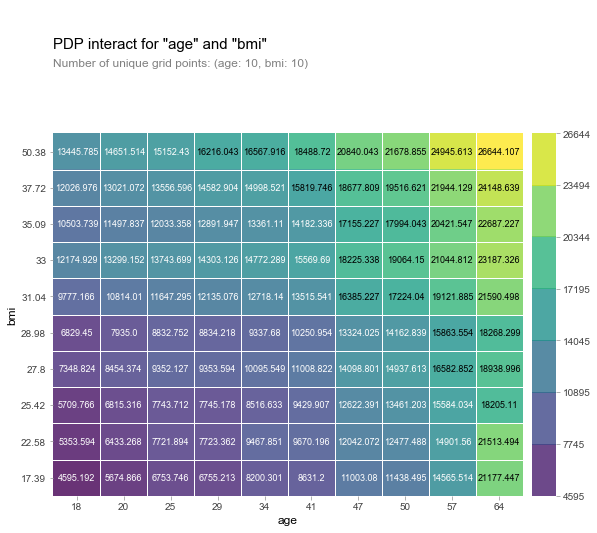

In [22]:
# pdp interact plot to compare 'charges' base on 'bmi' and 'age'
features = ['age', 'bmi']

interaction = pdp_interact(
    model=gb, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features, figsize=(9, 9));